In [79]:
import torch
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import numpy as np

In [2]:
class ResizeTransform:
    def __init__(self, new_width, new_height, instances=False): # instances if using bounding boxes set
        self.new_width = new_width
        self.new_height = new_height
        self.instances = instances

    def __call__(self, image, target):
        original_width, original_height = image.size
        scale_w = self.new_width / original_width
        scale_h = self.new_height / original_height

        resized_image = F.resize(image, (self.new_height, self.new_width))

        if self.instances:
            for box in target:
                bbox = box["bbox"]
                new_x_min = bbox[0] * scale_w
                new_y_min = bbox[1] * scale_h
                new_x_max = bbox[2] * scale_w
                new_y_max = bbox[3] * scale_h
                box["bbox"] = [new_x_min, new_y_min, new_x_max, new_y_max]

        return resized_image, target

In [3]:
def resize_and_scale(image, target):
    resize_transform = ResizeTransform(512, 512)
    image, target = resize_transform(image, target)
    image = transforms.ToTensor()(image)
    return image, target

In [7]:
coco_train = CocoDetection(root='images/train2017',
                           annFile='annotations/ann2017/captions_train2017.json',
                           transforms=resize_and_scale)

coco_val = CocoDetection(root='images/val2017',
                         annFile='annotations/ann2017/captions_val2017.json',
                         transforms=resize_and_scale)

loading annotations into memory...
Done (t=0.76s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [9]:
print('Number of samples in train:', len(coco_train))
print('Number of samples in validation:', len(coco_val))

img, target = coco_train[2]
print(target)
print(img.shape, target)

Number of samples in train: 118287
Number of samples in validation: 5000
[{'image_id': 30, 'id': 695774, 'caption': 'A flower vase is sitting on a porch stand.'}, {'image_id': 30, 'id': 696557, 'caption': 'White vase with different colored flowers sitting inside of it. '}, {'image_id': 30, 'id': 699041, 'caption': 'a white vase with many flowers on a stage'}, {'image_id': 30, 'id': 701216, 'caption': 'A white vase filled with different colored flowers.'}, {'image_id': 30, 'id': 702428, 'caption': 'A vase with red and white flowers outside on a sunny day.'}]
torch.Size([3, 512, 512]) [{'image_id': 30, 'id': 695774, 'caption': 'A flower vase is sitting on a porch stand.'}, {'image_id': 30, 'id': 696557, 'caption': 'White vase with different colored flowers sitting inside of it. '}, {'image_id': 30, 'id': 699041, 'caption': 'a white vase with many flowers on a stage'}, {'image_id': 30, 'id': 701216, 'caption': 'A white vase filled with different colored flowers.'}, {'image_id': 30, 'id': 

In [108]:
def show_image(img_tensor, annotation, instances=False):
    fig, ax = plt.subplots(1)
    ax.imshow(img_tensor.permute(1, 2, 0))

    for ann in annotation:
        if instances:
            bbox = ann['bbox']
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        else:
            print(ann["caption"])

    plt.show()

A flower vase is sitting on a porch stand.
White vase with different colored flowers sitting inside of it. 
a white vase with many flowers on a stage
A white vase filled with different colored flowers.
A vase with red and white flowers outside on a sunny day.


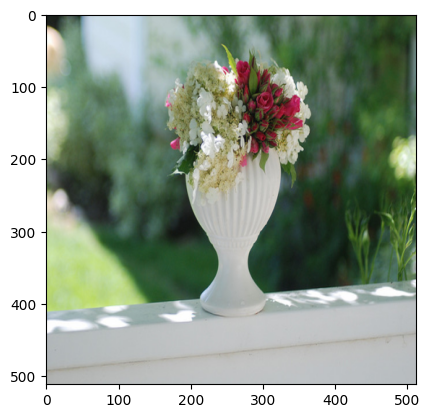

In [11]:
show_image(img, target)

In [12]:
train_loader = DataLoader(coco_train, batch_size=16, shuffle=True)
val_loader = DataLoader(coco_val, batch_size=16, shuffle=False)

In [99]:
def mask_image(image_tensor, patch_size, masking_ratio=0.75):
    """
    Randomly masks the given percentage of image patches, returning the masked image and mask
    """
    C, H, W = image_tensor.shape
    assert H % patch_size == 0 and W % patch_size == 0, "Image dimensions must be divisible by the patch size."

    num_patches = (H // patch_size) * (W // patch_size)
    num_masked_patches = int(num_patches * masking_ratio)
    patch_indices = torch.randperm(num_patches)[:num_masked_patches]
    mask = torch.ones((C, H, W))

    for idx in patch_indices:
        row = (idx // (W // patch_size)) * patch_size
        col = (idx % (W // patch_size)) * patch_size
        mask[:, row:row+patch_size, col:col+patch_size] = 0
    masked_image = image_tensor * mask
    return masked_image, mask

In [101]:
class NoiseScheduler:

    def __init__(self, num_steps, beta_start = 0.0001, beta_end = 0.02):
        self.betas = np.linspace(beta_start, beta_end, num_steps)

        self.alphas = 1 - self.betas
        self.alpha_bars = np.cumprod(self.alphas)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.alphas = torch.from_numpy(self.alphas).to(self.device).float()
        self.alpha_bars = torch.from_numpy(self.alpha_bars).to(self.device).float()
        self.betas = torch.from_numpy(self.betas).to(self.device).float()
        
    def add_noise(self, original_samples, timesteps, mask, mean=0.0, std=1.0):
        noisy_samples = None
        alpha_bars_t = self.alpha_bars[timesteps]
        if (original_samples.dim() == 3):
            alpha_bars_t = alpha_bars_t.unsqueeze(-1)
        noise = torch.randn_like(original_samples) * std + mean

        noisy_samples = torch.sqrt(alpha_bars_t).unsqueeze(-1) * original_samples + torch.sqrt(1 - alpha_bars_t).unsqueeze(-1) * noise * mask       
        return noisy_samples             

A flower vase is sitting on a porch stand.
White vase with different colored flowers sitting inside of it. 
a white vase with many flowers on a stage
A white vase filled with different colored flowers.
A vase with red and white flowers outside on a sunny day.


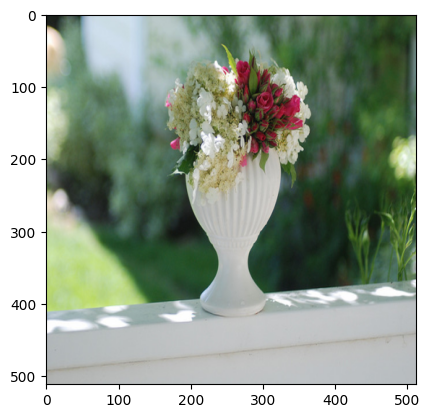

A flower vase is sitting on a porch stand.
White vase with different colored flowers sitting inside of it. 
a white vase with many flowers on a stage
A white vase filled with different colored flowers.
A vase with red and white flowers outside on a sunny day.


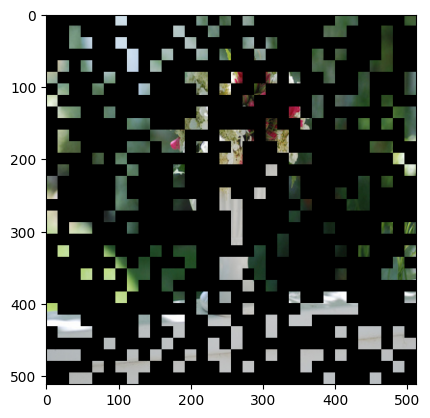

In [111]:
show_image(img, target)
noised_img, mask = mask_image(patch_size=16, image_tensor=img)
show_image(noised_img, target)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


A flower vase is sitting on a porch stand.
White vase with different colored flowers sitting inside of it. 
a white vase with many flowers on a stage
A white vase filled with different colored flowers.
A vase with red and white flowers outside on a sunny day.


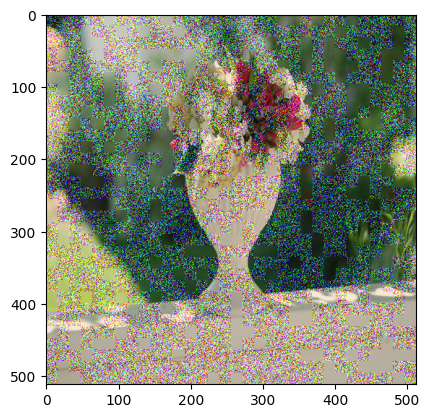

In [110]:
test_time = torch.tensor([20,40,60])
inverted = ~mask.bool()
output = NoiseScheduler(100).add_noise(img,test_time, mask=inverted)
show_image(output, target)
